# [Lab1/Group2] SVM problem

# 1. Задача оптимизации

$$ \min_{\xi_i, w, b} \sum_{i=1}^N \xi_i + λ\|w\|_2^2$$

\begin{cases}
\xi_i \geq& 1 - y_i (x_i^Tw + b) \\
\xi_i \geq& 0
\end{cases}\


$$ \text{Учитывая, что }
\xi_i = \max(0, 1 - y_i (x_i^Tw + b))$$

$$ \text{Получаем итоговую прямую задачу оптимизации:}$$ 

$$ \min_{\xi_i, w, b} \sum_{i=1}^N \max(0, 1 - y_i (x_i^Tw + b)) + λ\|w\|_2^2$$


$$\ x_i \text{ - объекты, вектора из X.}$$
$$\ y_i \text{ - метки классов.}$$
$$\ w, b \text{ - параметры разделяющей гиперплоскости.}$$
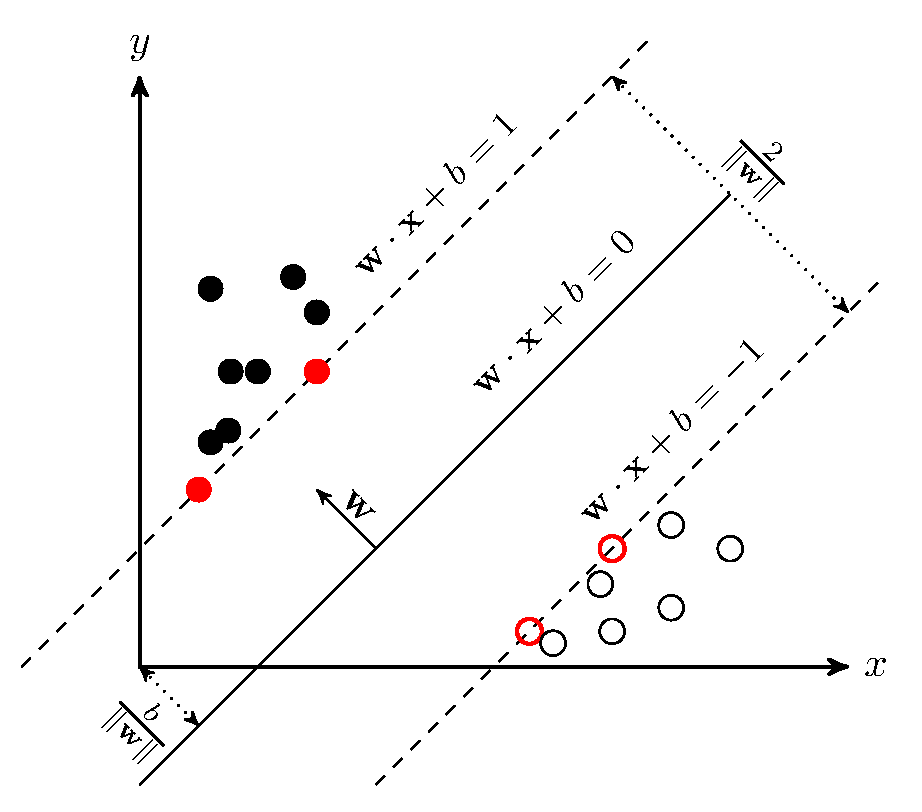

$$ \min_{\xi_i, w, b} \sum_{i=1}^N \xi_i + λ\|w\|_2^2$$


$$\xi_i \text{ - slack variables, штрафы на выбросы.}$$
\begin{cases}
\xi_i \geq& 1 - y_i (x_i^Tw + b) \\
\xi_i \geq& 0
\end{cases}
$$ \text{Получаем: }
\xi_i = \max(0, 1 - y_i (x_i^Tw + b))$$

$$\ \lambda \text{- штрафной коэффициент, насколько нам важны выбросы.}$$
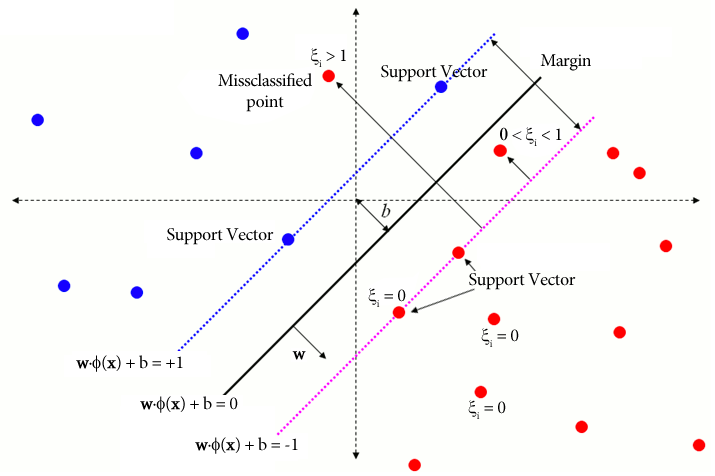

Смысл целевой функции - расположить разделяющую гиперплость максимальной ширины(минимизируя ||w||) между опорных векторов, при этом минимизируя выбросы.

# 2. Доказательство выпуклости

Докажем выпуклость задачи в таком виде:
$$ \min_{\xi_i, w, b} \sum_{i=1}^N \xi_i + λ\|w\|_2^2$$

\begin{cases}
\xi_i \geq& 1 - y_i (x_i^Tw + b) \\
\xi_i \geq& 0
\end{cases}

1.

$$ \ f_0(\xi_i)= \sum_{i=1}^N \xi_i \text{. Сумма выпуклых(линейных) функций.}$$

2.

$$ \ R(w)= \lambda\|w\|_2^2$$

$$  \ H(w_{11} ) =2 \text{. } H(w_{12} ) =0 $$ 
$$ \text{Матрица Гессе}  \ H(w ) \text{ неотрицательно определена.}$$

3.

$$ \ f_1(\xi_i, x_i, b)= - \xi_i + 1 - y_i (x_i^Tw + b)$$

$$\text{Функция}  \ - \xi_i + 1  \text{ линейная, значит выпуклая}$$

$$\text{Функция}   -y_i x_i^Tw - y_i b$$
$$\text{Матрица Гессе}  \ H(x_i, b)=0 \text{ неотрицательно определена.}$$

$$\text{Получаем, что} f_1 \text{- выпуклая, как сумма выпуклых функций} $$

4.

$$ \ f_2(\xi_i)= -\xi_i$$

$$\text{Линейная функция. }
 \ H(\xi_i)=0  \text{ Матрица Гессе неотрицательно определена.}$$

f0, f1, f2, R(x) - выпуклые функции. Следовательно задача выпуклая.


## 4. Для каждого значения n $\in$ {2, 10, 20, ..., 100} сгенерируйте N = 100 тестовых примеров

In [ ]:
import cvxpy as cvx
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
np.random.seed(0)

In [ ]:
from sklearn.model_selection import train_test_split
def gen_lin_separable_data(n=2, N=100, with_test=False, means_=[[0], [2]], covs_=[[[0.3]], [[0.2]]]):
    means = np.array(means_)
    covs = np.array(covs_)
    if with_test:
        N_ = int(N * 1.3)
    else:
        N_ = N
    X1 = np.random.multivariate_normal(means[0], covs[0], (N_, n))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(means[1], covs[1], (N_, n))
    y2 = np.ones(len(X2)) * -1
    X = np.vstack((X1, X2)).reshape((2*N_, n))
    y = np.hstack((y1, y2))
    if with_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        return X_train, X_test, y_train, y_test
    return X, y

Визуализация сгенерированных кластеров при n=2

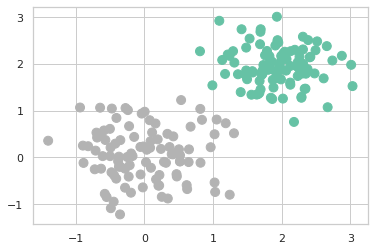

In [ ]:
X, y = gen_lin_separable_data(means_=[[0], [2]], covs_=[[[0.3]], [[0.2]]])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set2', s=80)
plt.show()

## 5. Решите задачу с помощью CVX, исследуйте зависимости:

- Зависимость **среднего по N примерам времени** решения задачи размерности n;

In [ ]:
class SVM(BaseEstimator, ClassifierMixin):

    def __init__(self, lambda_=0.5, verbose=False, max_iter=1000, solver=cvx.OSQP):
        
        self.lambda_ = lambda_

        self.coef = None
        self.bias = None
        self.labels = None

        self.X = None
        self.y = None
        
        # solver setup
        self.verbose = verbose
        self.max_iter = max_iter
        self.solver = solver

    def fit(self, X, y):
        if len(np.unique(y)) > 2:
            raise RuntimeError

        self.X = X.copy()

        self.labels = np.array(sorted(np.unique(y)))
        assert len(self.labels) == 2
        y[y == self.labels[0]] = -1
        y[y == self.labels[1]] = 1

        n, d = self.X.shape
        w = cvx.Variable(shape=(d,))
        bias = cvx.Variable()
        R = cvx.norm(w, 2)**2

        loss = cvx.sum(cvx.pos(1 - cvx.multiply(y, X @ w + bias))) / float(n)
        cvx_problem = cvx.Problem(cvx.Minimize(loss + self.lambda_ * R))
        cvx_problem.solve(verbose=self.verbose, max_iter=self.max_iter, solver=self.solver, kktsolver='robust', warm_start=False)

        self.coef = np.array(w.value).squeeze()
        self.bias = bias.value

        return self

    def predict(self, X):
        p = np.dot(self.coef, X.T) + self.bias
        return self.labels[(p > 0).astype(int)]

In [ ]:
from datetime import datetime

lambda_ = 0.5
ns = [2] + list(range(10, 110, 10))
num_tries = 10
times = []

for n in ns:
    start = datetime.now()
    for _ in range(num_tries):
        X, y = gen_lin_separable_data(n=n)
        clf = SVM(lambda_=lambda_, max_iter=10000, verbose=False, solver=cvx.CVXOPT)
        clf.fit(X, y)
    end = (datetime.now() - start).total_seconds()
    times.append(end / num_tries)

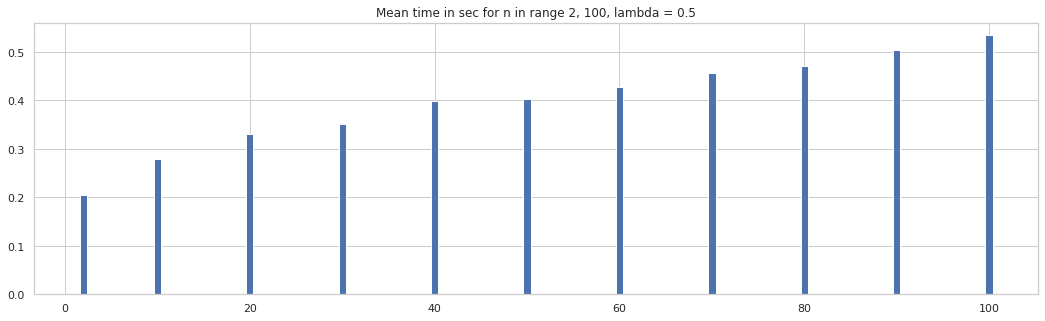

In [ ]:
f, ax = plt.subplots(figsize=(18,5))
plt.bar(ns, times)
plt.title(f"Mean time in sec for n in range 2, 100, lambda = {lambda_}")
plt.show()

По графику видим, что время работы незначительно увеличивается с ростом числа признаков.

- Для случая n=2 и λ!=0 зависимость **среднего** оптимального значения задачи от размерности n

In [ ]:
lambda_grid = [0.01, 0.05, 0.1]+list(np.arange(0.5, 5.5, 0.5))

loss_hist = []
reg_hist = []

N_samples=100
n = 2
X, y = gen_lin_separable_data(n=n, N=N_samples)

# generate with lambdas in range [0.1, 5.0]
for lambda_ in lambda_grid:
    print(f'Processing lambda={lambda_}')
    clf = SVM(lambda_=lambda_, max_iter=10000, verbose=False, solver=cvx.CVXOPT)
    clf.fit(X, y)

    w = clf.coef
    bias = clf.bias
    R = np.linalg.norm(w, 2)**2
    loss = sum([np.max([0, 1 - (y[i]*X[i]@w+ bias)]) for i in range(N_samples)])/N_samples
    
    loss_hist.append(loss)
    reg_hist.append(R)

Processing lambda=0.01
Processing lambda=0.05
Processing lambda=0.1
Processing lambda=0.5
Processing lambda=1.0
Processing lambda=1.5
Processing lambda=2.0
Processing lambda=2.5
Processing lambda=3.0
Processing lambda=3.5
Processing lambda=4.0
Processing lambda=4.5
Processing lambda=5.0


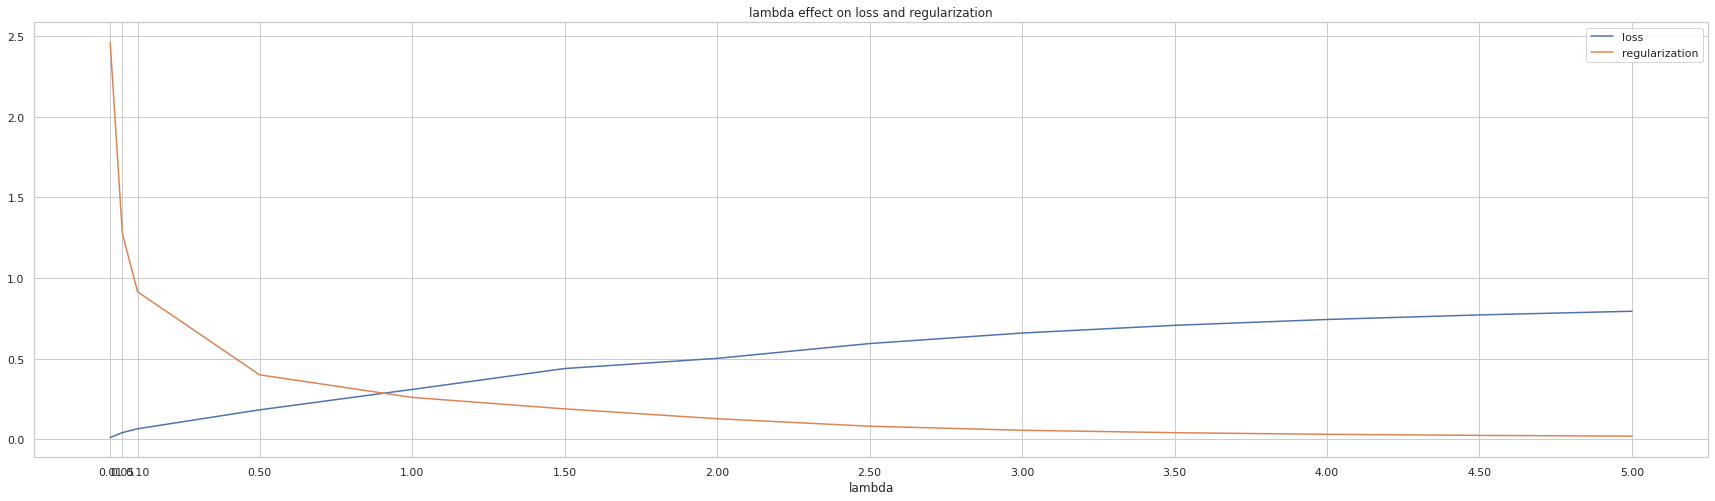

In [ ]:
f, ax = plt.subplots(figsize=(30,8))
plt.plot(lambda_grid, loss_hist)
plt.plot(lambda_grid, reg_hist)
plt.title(f"lambda effect on loss and regularization")
plt.legend(['loss', 'regularization'])
ax.set_xticks(lambda_grid)
ax.set_xlabel('lambda')
plt.show()

Видим, что с ростом lambda убывает значение R(w) и возрастает функция потерь.

- Для случая n=2, проведите графическую интерпретацию результатов

In [ ]:
def plot_decision_(clf, X, y, cmap='Set1'):

    w = clf.coef
    b = clf.bias

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=80)

    n_samples = X.shape[0]//2
    
    d1_min = np.min([X[:n_samples,0], X[n_samples:,0]])
    d1_max = np.max([X[:n_samples,0], X[n_samples:,0]])

    d2_at_mind1 = (-w[0]*d1_min - b) / w[1]
    d2_at_maxd1 = (-w[0]*d1_max - b) / w[1]
    sup_up_at_mind1 = (-w[0]*d1_min - b - 1) / w[1]
    sup_up_at_maxd1 = (-w[0]*d1_max - b - 1) / w[1]
    sup_dn_at_mind1 = (-w[0]*d1_min - b + 1) / w[1]
    sup_dn_at_maxd1 = (-w[0]*d1_max - b + 1) / w[1]

    plt.plot([d1_min,d1_max], [d2_at_mind1, d2_at_maxd1], color='gray')
    plt.plot([d1_min,d1_max], [sup_up_at_mind1, sup_up_at_maxd1],'--', color='gray')
    plt.plot([d1_min,d1_max], [sup_dn_at_mind1, sup_dn_at_maxd1],'--', color='gray')
    plt.ylim([np.floor(np.min([X[:n_samples,1],X[n_samples:,1]])), np.ceil(np.max([X[:n_samples,1], X[n_samples:,1]]))])


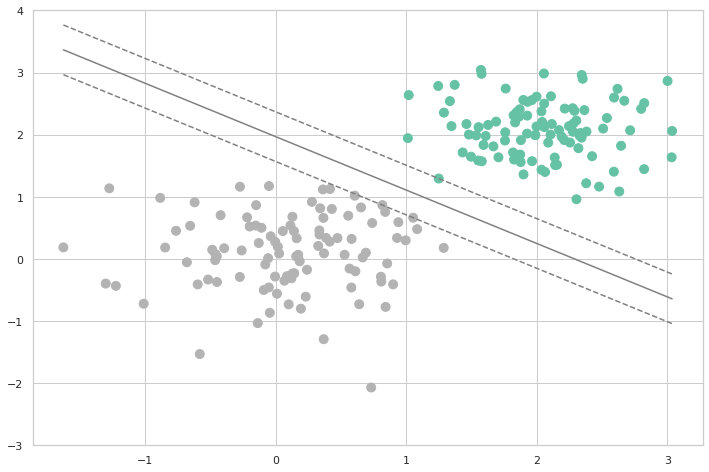

In [ ]:
X, y = gen_lin_separable_data(n=2)

plt.figure(figsize=(12, 8))
clf = SVM(lambda_=0.0001, max_iter=10000, verbose=False, solver=cvx.CVXOPT)
clf.fit(X, y)
plot_decision_(clf, X, y, cmap='Set2')

## Additional tests

In [ ]:
X_train, y_train = gen_lin_separable_data(n=2, means_=[[1], [3]], covs_=[[[1]], [[1.5]]])
clf = SVM(lambda_=0.001, max_iter=10000, verbose=False, solver=cvx.CVXOPT)
clf.fit(X_train, y_train)

SVM(lambda_=0.001, max_iter=10000, solver='CVXOPT')

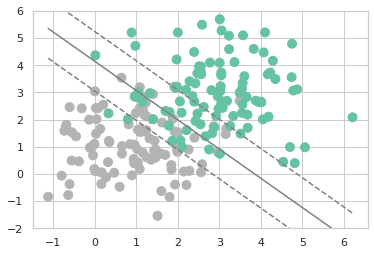

In [ ]:
plot_decision_(clf, X_train, y_train, cmap='Set2')

In [ ]:
X_test, y_test = gen_lin_separable_data(n=2, N=30)
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8166666666666667

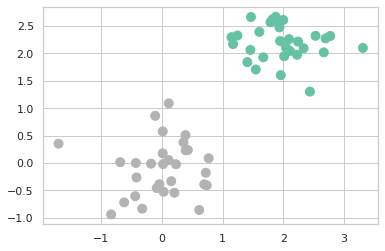

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='Set2', s=80)
plt.show()

In [ ]:
X_test, y_test = gen_lin_separable_data(means_=[[1], [3]], covs_=[[[0.1]], [[0.5]]])
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.985

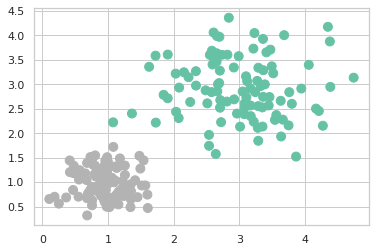

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='Set2', s=80)
plt.show()

## Вывод: ?
